## Overview
The scope of this project is to analyse the impact of weather phenomeas on the wine production of Alentejio and Douro regions.
The fist step is to consider the production of single producers and analyse it across the years, correlating with weather conditions
The second step is to consider the grapes that are commons to the two regions and compare the production

## 1. Load packages/modules

In [78]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopy.geocoders
import rasterio as rio
import glob as glb
import os

from cartopy.feature import ShapelyFeature
from shapely.geometry import Point, box
from functools import partial
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import GoogleV3
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from fiona.crs import from_epsg

%matplotlib inline

# constant
douro_path = "./data_source/douro/"  # path to load Douro datasets
alentejio = "./data_source/alentejo/" # path to load Alentejio datasets 

ModuleNotFoundError: No module named 'pycrs'

## 2. Methods section

In [2]:
def addressGeocoded(df,gc):
    '''
    This function accepts a dataframe and a geocode object and returns a geo dataframe
    
    :param df: dataframe with addresses
    :param gc: geocode object
    
    :returns geodataframe
    '''
    tmp_df = df.copy() # create a copy of the original dataframe, in this way no changes will be applied to the original one
    tmp_df['geolocation'] = tmp_df['address'].apply(gc) # translate address into coordinate
    tmp_df['geometry'] = tmp_df['geolocation'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None) #extract tuple point location
    tmp_df['geometry'] = tmp_df['geometry'].apply(Point) # convert tuple in shapely geometry point
    gdf = gpd.GeoDataFrame(tmp_df)
    gdf.set_crs("EPSG:3763", inplace=True) #Set the projection to the ETRS89/PT-TMS09
    gdf = gdf.drop(columns=['geolocation']) #Drop geolocation information; shapefile only accept one geometry column when saving the geodataframe
    gdf.to_file("./data_source/douro/douro_wine_producers.shp") # save the geodataframe in shape file; in this way no queries are sent to Google geocoding service
    return gdf

def img_display(image, ax, bands, transform, extent):
    '''
    This is where you should write a docstring.
    '''
    # first, we transpose the image to re-order the indices
    dispimg = image.transpose([1, 2, 0])
    
    # next, we have to scale the image.
    dispimg = dispimg / dispimg.max()
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], transform=transform, extent=extent)
    
    return handle, ax

## 3. Load the data

Portugal municipalities and parishes are loaded from the shapefile *Cont_AAD_CAOP2020*; source [**DgTerritorio**](https://www.dgterritorio.gov.pt/cartografia/cartografia-tematica/caop?language=en) and load Douro municipalities and parishes dataset reporting the informtion where the douro wine is produced; source [**IVV**](https://www.ivv.gov.pt/np4/%7B$clientServletPath%7D/?newsId=1736&fileName=IVV_WEB_TB.PDF)

In [3]:
### Laod Portugal municipalities.
pt_municipalities_gdf = gpd.read_file("./data_source/Cont_AAD_CAOP2020/Cont_AAD_CAOP2020.shp")
#pt_municipalities_gdf.shape
#pt_municimunicipalities_gdf.head(15)

In [4]:
### Load Douro municipalities and parishes dataset where douro wine is produced.
douro_municipalities_df = pd.read_excel(douro_path+"douro_municipality_parish.xlsx")
douro_municipalities_df.shape
douro_municipalities_df.head()

,Area Geografica,Concelhos,Frequesias
0,Baxio Corgo,Mesão Frio,NaN
1,Baxio Corgo,Peso da Régua,NaN
2,Baxio Corgo,Santa Marta de Penaguião,NaN
3,Baxio Corgo,Vila Real,Abaças
4,Baxio Corgo,Vila Real,Ermida


In [5]:
# Get the list of unique Douro municipalities
unique_munic = douro_municipalities_df['Concelhos'].unique()
pt_douro_munic_gdf = pt_municipalities_gdf[pt_municipalities_gdf['Concelho'].apply(lambda muni: muni in unique_munic)] #extract Douro municipalities from Portugal dataset

In [6]:
pt_douro_munic_gdf.head() #Check the dataframe

,Dicofre,Freguesia,Concelho,Distrito,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,geometry
214,090410,Mata de Lobos,Figueira de Castelo Rodrigo,Guarda,ÁREA PRINCIPAL,3697.29,3697.29,Mata de Lobos,"POLYGON ((108183.030 137946.011, 107387.875 13..."
229,090918,Prova e Casteição,Mêda,Guarda,ÁREA PRINCIPAL,2602.61,2602.61,Prova e Casteição,"POLYGON ((69087.504 144866.380, 69070.975 1448..."
660,090406,Escalhão,Figueira de Castelo Rodrigo,Guarda,ÁREA PRINCIPAL,7880.74,7880.74,Escalhão,"POLYGON ((100800.954 151822.754, 100845.704 15..."
661,180511,Lazarim,Lamego,Viseu,ÁREA PRINCIPAL,1653.84,1653.84,Lazarim,"POLYGON ((25364.680 151852.479, 25377.150 1518..."
663,091401,Almendra,Vila Nova de Foz Côa,Guarda,ÁREA PRINCIPAL,5440.65,5440.65,Almendra,"POLYGON ((95730.137 152175.506, 95762.159 1520..."


In [7]:
# Check all the douro wine production municipalities are in the new sub geodataframe 
print(pt_douro_munic_gdf['Concelho'].unique().shape)
print(unique_munic.shape)
test_list = []
for element in unique_munic:
    if element not in pt_douro_munic_gdf['Concelho'].unique():
        test_list.append(element)
print(test_list)
pt_municipalities_gdf[pt_municipalities_gdf['Freguesia']=='Escalhão']

(20,)
(20,)
[]


,Dicofre,Freguesia,Concelho,Distrito,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,geometry
660,090406,Escalhão,Figueira de Castelo Rodrigo,Guarda,ÁREA PRINCIPAL,7880.74,7880.74,Escalhão,"POLYGON ((100800.954 151822.754, 100845.704 15..."


In [8]:
### Load Douro wine producers dataset
douro_wine_producers_df = pd.read_excel(douro_path+"douro_wine_producers_list.xlsx")
douro_wine_producers_df.head(15)

,producer,address
0,Niepoort,"670 Rua Candido do Reis, Vila Nova de Gaia 4400"
1,Poeira,"Provesende 5060, Villa Real"
2,Quinta do Couquinho,"Horta da Vilarica, 5160-101 Torre de Moncorvo,..."
3,Quinta do Judeu,"Estrada EM313, Peso da Regua 5050, Vila Real"
4,Quinta do Pego,"Estrada Nacional 222, 5120-493 Valenca do Dour..."
5,Quinta Dos Castelares,"Avenida Guerra Junqueiro, 5180-104 Freixo de E..."
6,1912winemakers,Av. Dr. Antunes Guimarães 255/277 4100 - 079 P...
7,Abraco,"Rua do Liboso 286, 4510-076 Jovim, Porto"
8,A Brites Aguiar,"5130-520 Varzea de Trevoes, Sao Joao da Pesque..."
9,Adega Aromatica,"Rua da Igreja, Seara, 5130-070 Ervedosa do Dou..."


In [9]:
douro_wine_producers_df.shape

(167, 2)

In [ ]:
##############################################################
### Note: this cell can be run only once to geocode wine producers address.
### the file is then saved on the harddisk.
### Google account with API key is needed in order to operate
##############################################################

#Instance Google connection for geocoding
geopy.geocoders.options.default_user_agent = 'wine_app'
geopy.geocoders.options.default_scheme = 'https'
with open("./data_source/apikey.txt") as f:   #load Google API key
    apikey = f.readline()
    f.close
geolocator = GoogleV3(api_key=apikey)
geocode = partial(geolocator.geocode, language="en")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)
# Query Google
douro_wine_producers_gdf = addressGeocoded(douro_wine_producers_df,geocode)
##################################################################################################################

In [10]:
douro_wine_producers_gdf = gpd.read_file("./data_source/douro/douro_wine_producers.shp")
douro_wine_producers_gdf.head(10)

,producer,address,geometry
0,Niepoort,"670 Rua Candido do Reis, Vila Nova de Gaia 4400",POINT (41.13104 -8.61094)
1,Poeira,"Provesende 5060, Villa Real",POINT (41.21715 -7.56667)
2,Quinta do Couquinho,"Horta da Vilarica, 5160-101 Torre de Moncorvo,...",POINT (41.23191 -7.12256)
3,Quinta do Judeu,"Estrada EM313, Peso da Regua 5050, Vila Real",POINT (41.17185 -7.73081)
4,Quinta do Pego,"Estrada Nacional 222, 5120-493 Valenca do Dour...",POINT (41.15907 -7.55528)
5,Quinta Dos Castelares,"Avenida Guerra Junqueiro, 5180-104 Freixo de E...",POINT (41.08775 -6.80785)
6,1912winemakers,Av. Dr. Antunes Guimarães 255/277 4100 - 079 P...,POINT (41.16581 -8.66137)
7,Abraco,"Rua do Liboso 286, 4510-076 Jovim, Porto",POINT (41.11999 -8.50855)
8,A Brites Aguiar,"5130-520 Varzea de Trevoes, Sao Joao da Pesque...",POINT (41.09717 -7.45998)
9,Adega Aromatica,"Rua da Igreja, Seara, 5130-070 Ervedosa do Dou...",POINT (41.16642 -7.47293)


In [59]:
### Load Douro Region shapefile
douro_gdf = gpd.read_file(douro_path+"RDD_ETRS89/RDD_ETRS89.shp")
print(douro_gdf.crs)
douro_gdf

epsg:4258


,OBJECTID,ID,ÁREA,PERIMETRO,OBSERVAÇÕE,ID1,Shape_area,Shape_len,REGIÃO,Centroid_X,Centroid_Y,geometry
0,1,1.0,2.474209e+09,674115.534151,None,1.0,2.474209e+09,674115.534151,RDD,0,0,"MULTIPOLYGON Z (((-7.76909 41.07097 0.00000, -..."


## 4. Create a map of Douro
To dispaly the images Cartopy and Matplotlib are used; The first object that needs to be created is the fig object used as container for the images

-7.91537076541469 40.922027216580084 -6.750437785385963 41.52976336745321


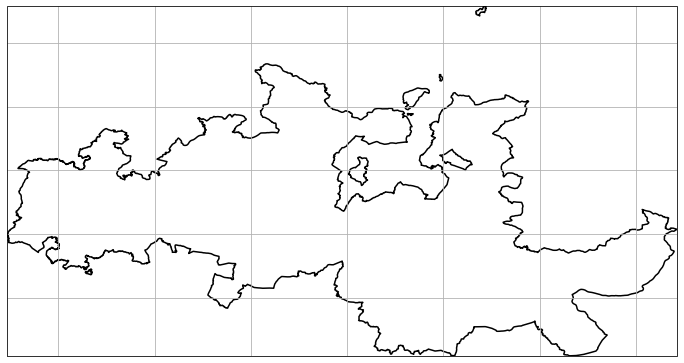

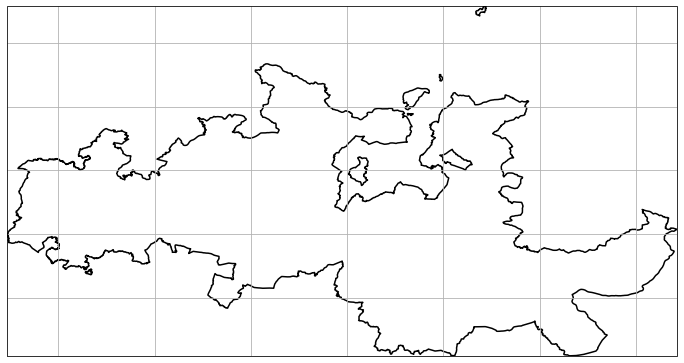

In [12]:
# Create the figure layout
pt_crs = ccrs.UTM(29) #Universal Trasverse Marcator system for Portugal
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.Mercator()) # create axes object with Maractor projection
ax.gridlines()
douro_region = ShapelyFeature(douro_gdf['geometry'], pt_crs, edgecolor='k',linewidth=1.5,facecolor='w')
ax.add_feature(douro_region)# add the douro region borders
# using the boundary of the shapefile features, zoom the map to our area of interest
xmin, ymin, xmax, ymax = douro_gdf.total_bounds #total_bounds gives output as xmin, ymin, xmax, ymax
print(xmin,ymin,xmax,ymax)
ax.set_extent([xmin, xmax, ymin, ymax], crs=pt_crs) #set_extent allow to zoom in the area of interest
fig

### Add Features
Bofore adding features such as point location, other type of data, it's worth to compare the CRS in the loaded dataset and change the projection where is needed
#### Municipalities & parishes

In [13]:
pt_douro_munic_gdf.crs

<Projected CRS: EPSG:3763>
Name: ETRS89 / Portugal TM06
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Portugal - mainland - onshore.
- bounds: (-9.56, 36.95, -6.19, 42.16)
Coordinate Operation:
- name: Portugual TM06
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The Portugal municipality shapefile uses EPSG:3763 that it's a prjection and the coordinates are geometric, while the Douro image uses geographic coordinates. The sub set of Portugal municipalities related to Douro needs to be converted before being plotted

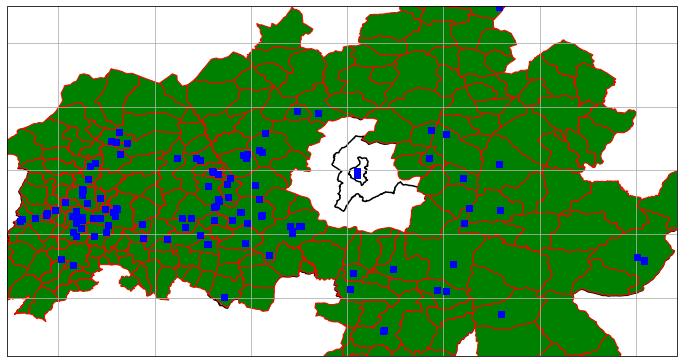

In [14]:
pt_douro_munic_wgs84 = pt_douro_munic_gdf.to_crs("EPSG:4326") # Conversion from Cartesian to Geographic coordinates
douro_municip = ShapelyFeature(pt_douro_munic_wgs84['geometry'], pt_crs, edgecolor='red',linewidth=1,facecolor='green')
ax.add_feature(douro_municip)# add the douro region borders
ax.plot(douro_wine_producers_gdf.geometry.y,douro_wine_producers_gdf.geometry.x,'s', color='blue',transform=pt_crs)
fig

## 5. Create a raster map of Douro
In the following cells the mosaic technique is used to create a raster map of Douro region by combining [Landsat 8](https://earthexplorer.usgs.gov/) of true color images obtained combining visible bands 2,3 and 4 (Blue,Green and Red, rispectively). The image is then saved for further usage

In [15]:
########################################################
### Note: the following steps can be done only once ####
########################################################
# Create an list with the path of needed images
query = os.path.join(douro_path+"Sat_images","LT05*.tif")
dem_file = glb.glob(query) # glob function can be used to list files from a directory with specific criteria
dem_file

['./data_source/douro/Sat_images\\LT05_L1TP_203031_20111014_20200820_02_T1_refl.tif',
 './data_source/douro/Sat_images\\LT05_L1TP_203032_20110912_20200820_02_T1_refl.tif',
 './data_source/douro/Sat_images\\LT05_L1TP_204031_20110919_20200820_02_T1_refl.tif']

In [21]:
src_files_to_mosaic = [] # Create a list for the source files
# Iterate over raster files and add them to source -list in 'read mode'
for f in dem_file:
    src = rio.open(f)
    print(src.crs)
    src_files_to_mosaic.append(src)
mosaic, out_trans = merge(src_files_to_mosaic) #use merge to create a mosaic from the images

EPSG:32629
EPSG:32629
EPSG:32629


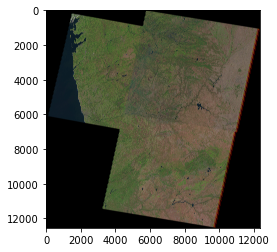

<AxesSubplot:>

In [22]:
# Test if the image is correct
show(mosaic,cmap='terrain')

In [23]:
#Update medata data information and save the image on harddisk
print(src.meta) # print the metadata information of each single image
out_meta = src.meta.copy() #create a copy of metadata information
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "compress": 'JPEG',
                 "jpeg_quality": 60
                }
               )
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8001, 'height': 7141, 'count': 3, 'crs': CRS.from_epsg(32629), 'transform': Affine(30.0, 0.0, 462885.0,
       0.0, -30.0, 4731015.0)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 12321, 'height': 12541, 'count': 3, 'crs': CRS.from_epsg(32629), 'transform': Affine(30.0, 0.0, 462885.0,
       0.0, -30.0, 4736115.0), 'compress': 'JPEG', 'jpeg_quality': 60}


In [24]:
# Write the mosaic raster to disk
with rio.open(douro_path+"Sat_images/Douro_region_Mosaic.tif", "w", **out_meta) as dest:
    dest.write(mosaic)
    dest.close()
##########################################
### End of the bloack
##########################################

## 6. Load raster data and display with matplotlib and cartpy

In [25]:
with rio.open(douro_path+"Sat_images/Douro_region_Mosaic.tif") as dataset:
    img = dataset.read()
    xmin, ymin, xmax, ymax = dataset.bounds
    print(dataset.bounds)
    print(dataset.crs)
    print(img)
    print(img.shape)

BoundingBox(left=462885.0, bottom=4359885.0, right=832515.0, top=4736115.0)
EPSG:32629
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
(3, 12541, 12321)


In [60]:
xmin, ymin, xmax, ymax = douro_gdf.total_bounds
bbox = box(xmin, ymin, xmax, ymax)
print(bbox)

POLYGON ((-6.750437785385963 40.92202721658008, -6.750437785385963 41.52976336745321, -7.91537076541469 41.52976336745321, -7.91537076541469 40.92202721658008, -6.750437785385963 40.92202721658008))


In [63]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0],crs="4258")

In [64]:
geo

,geometry
0,"POLYGON ((-6.75044 40.92203, -6.75044 41.52976..."


In [80]:
print(dataset.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 12321, 'height': 12541, 'count': 3, 'crs': CRS.from_epsg(32629), 'transform': Affine(30.0, 0.0, 462885.0,
       0.0, -30.0, 4736115.0)}


In [67]:
geo = geo.to_crs(crs=dataset.crs)

In [68]:
print(geo)

                                            geometry
0  POLYGON ((689421.408 4532537.849, 687674.622 4...


In [ ]:
# Display raster
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=pt_crs))

In [69]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [70]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[689421.4084376141, 4532537.848628825], [687674.6223649163, 4600011.906586491], [590485.3645378175, 4598136.411753755], [591327.1789624243, 4530667.665791824], [689421.4084376141, 4532537.848628825]]]}]


In [75]:
dataset = rio.open(douro_path+"Sat_images/Douro_region_Mosaic.tif")

In [76]:
out_img, out_transform = mask(dataset, shapes=coords, crop=True)

In [81]:
out_img.shape[1]

2313

In [77]:
out_meta = dataset.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 12321, 'height': 12541, 'count': 3, 'crs': CRS.from_epsg(32629), 'transform': Affine(30.0, 0.0, 462885.0,
       0.0, -30.0, 4736115.0)}


In [82]:
 out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform
                 }
                )

In [83]:
with rio.open(douro_path+"Sat_images/Douro_region_Mosaic_reduced.tif", "w", **out_meta) as dest:
    dest.write(out_img)
    dest.close()

In [ ]:
ax.imshow(img[0:3],cmap='terrain',transform=pt_crs)

In [ ]:
h, ax = img_display(img, ax, [2, 1, 0], pt_crs, [xmin, xmax, ymin, ymax])
fig # just to save you from scrolling back up to see